In [1]:
# processing
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/figS15/'

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

## Find the transcription start site
df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [6]:
promoter.find(crp_site)

41

In [7]:
crp_emat_raw = pd.read_table(fdir + 'energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy() * 1.62
crp_emat = tregs.simulate.fix_wt(crp_emat, crp_site).T

### Simple activation with induction

In [8]:
def get_pactive(c, M_AL, M_AR, M_IL, M_IR, e_AI):
    z = np.zeros(8)
    z[0] = 1
    z[1] = c / M_AL
    z[2] = c / M_AR
    z[3] = z[1] * z[2]
    z[4] = np.exp(- 2 * e_AI)
    z[5] = z[4] * c / M_IL
    z[6] = z[4] * c / M_IR
    z[7] = z[4] * (c / M_IL) * (c / M_IR)

    return np.sum(z[:4]) / np.sum(z)

In [9]:
def simact_pbound_with_inducer(p_seq, a_seq, n_NS, n_p, n_a,
                               p_emat, a_emat,
                               ep_wt, eaa_wt, eai_wt,
                               c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_aa = tregs.simulate.get_weight(a_seq, a_emat, e_wt=eaa_wt)
    w_ai = tregs.simulate.get_weight(a_seq, a_emat, e_wt=eai_wt)
    pactive = get_pactive(c, M_AL, M_AR, M_IL, M_IR, e_AI)

    z = np.zeros(6)
    z[0] = 1
    z[1] = n_p / n_NS * w_p
    z[2] = pactive * n_a / n_NS * w_aa
    z[3] = (1 - pactive) * n_a / n_NS * w_ai
    z[4] = z[2] * z[1] * np.exp(-e_int_A)
    z[5] = z[3] * z[1] * np.exp(-e_int_I)

    return (z[1] + z[4] + z[5]) / np.sum(z)

In [10]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [11]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
eaa_wt = -13
eai_wt = -1
e_int_A = -4
e_int_I = 0
e_AI = -2

M_AL = 3 * 10**(-6)
M_AR = 3 * 10**(-6)
M_IL = 10**(-7)
M_IR = 10**(-7)

signal = []
inducer_conc = []
for i in np.arange(-10, -2, 0.2):
    c = 10**i
    inducer_conc.append(c)

    tmp = []
    for i in range(len(mutant_bank)):
        df = tregs.simulate.sim(promoter, simact_pbound_with_inducer, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, eaa_wt, eai_wt,
                          c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI],
                          preset_mutants=mutant_bank[i])

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        tmp.append(np.mean(footprint[(-70+115):(-52+116)]))
    signal.append(np.mean(tmp))

In [12]:
norm_inducer_conc = np.asarray(inducer_conc)

In [13]:
def sigmoid(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

p0 = [-max(signal), min(signal), 1, 1] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, norm_inducer_conc, signal, p0, maxfev=10000)

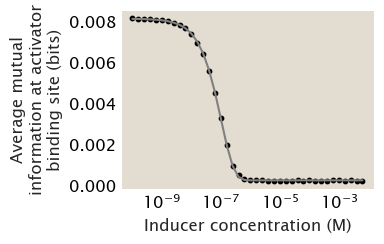

In [14]:
# plot signal vs inducer concentration
fig, ax = plt.subplots(figsize=(4, 2.6))
ax.scatter(inducer_conc, signal, color='k', s=10)
ax.plot(inducer_conc, sigmoid(norm_inducer_conc, *popt), color='grey')
ax.set_xscale('log')
#ax.set_xticks([0.001, 0.01, 0.1, 1, 10])
#ax.set_xlabel('Inducer concentration / ' + r'$K_A$')
ax.set_xlabel('Inducer concentration (M)')
ax.set_ylabel('Average mutual\ninformation at activator\nbinding site (bits)')
plt.tight_layout()
plt.savefig(out_fdir + 'inducer_activator.pdf', bbox_inches='tight')

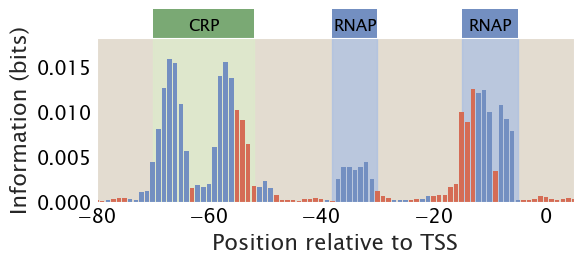

In [15]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
eaa_wt = -13
eai_wt = -1
e_int_A = -4
e_int_I = 0
e_AI = -2

M_AL = 3 * 10**(-6)
M_AR = 3 * 10**(-6)
M_IL = 10**(-7)
M_IR = 10**(-7)

c = 10**(-9)
df = tregs.simulate.sim(promoter, simact_pbound_with_inducer, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, eaa_wt, eai_wt,
                          c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=6,
                               outfile=out_fdir + 'inducer_activator_fp1.pdf')

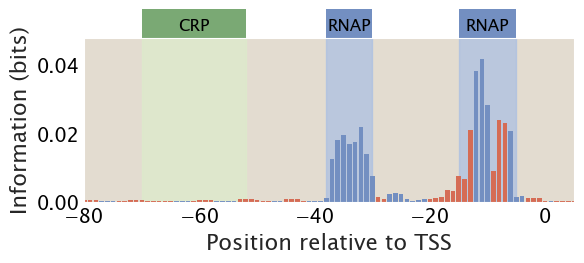

In [16]:
n_NS = len(genome)
n_p = 5000
n_a = 50
ep_wt = -3
eaa_wt = -13
eai_wt = -1
e_int_A = -4
e_int_I = 0
e_AI = -2

M_AL = 3 * 10**(-6)
M_AR = 3 * 10**(-6)
M_IL = 10**(-7)
M_IR = 10**(-7)

c = 10**(-3)
df = tregs.simulate.sim(promoter, simact_pbound_with_inducer, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, eaa_wt, eai_wt,
                          c, M_AL, M_AR, M_IL, M_IR, e_int_A, e_int_I, e_AI])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=6,
                               outfile=out_fdir + 'inducer_activator_fp2.pdf')